# Speech Emotion Recognition with CNN-BiLSTM-Attention

This notebook implements Speech Emotion Recognition (SER) using **CNN + BiLSTM + Attention**, with added improvements:
- Noise Reduction (Preprocessing)
- 3-second Segmentation of Audio Files
- Learning Rate Scheduler
- Train/Validation/Test Split (70/15/15)
- Early Stopping to prevent overfitting
- Visualizations: Dataset summary, audio waveform, spectrograms, training/validation curves

This setup is designed for professional research (Final Year Project quality).

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import IPython.display as ipd

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd

/content


In [4]:
cd drive/'My Drive'/'Colab Notebooks'/'Emotion Speech Recognition'/

/content/drive/My Drive/Colab Notebooks/Emotion Speech Recognition


## Load Dataset and Apply Noise Reduction

In [5]:
# Example path (update with your dataset path)
DATASET_PATH = "./Dataset"

def reduce_noise(audio, sr):
    # Simple noise reduction by spectral gating
    spec = librosa.stft(audio)
    mag, phase = librosa.magphase(spec)
    noise_profile = np.mean(mag, axis=1, keepdims=True)
    mask = mag > noise_profile
    cleaned = mask * mag * phase
    return librosa.istft(cleaned)

def extract_features(file_path, sr=22050, max_len=3):
    audio, sr = librosa.load(file_path, sr=sr)
    audio = reduce_noise(audio, sr)
    # Ensure 3s segmentation
    if len(audio) > sr*max_len:
        audio = audio[:sr*max_len]
    else:
        pad = sr*max_len - len(audio)
        audio = np.pad(audio, (0, pad))
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    return mfccs.T

## Dataset Preparation with Train/Validation/Test Split

In [6]:
X, y = [], []
labels = os.listdir(DATASET_PATH)
for label in labels:
    files = os.listdir(os.path.join(DATASET_PATH, label))
    for f in files:
        path = os.path.join(DATASET_PATH, label, f)
        feature = extract_features(path)
        X.append(feature)
        y.append(label)

X = np.array(X)
y = LabelEncoder().fit_transform(y)
X = np.expand_dims(X, -1)

# Split 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (1799, 130, 40, 1) Val: (386, 130, 40, 1) Test: (386, 130, 40, 1)


## Model: CNN + BiLSTM + Attention

In [7]:
def attention_block(inputs):
    attention = layers.Dense(1, activation='tanh')(inputs)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(inputs.shape[-1])(attention)
    attention = layers.Permute([2,1])(attention)
    return layers.Multiply()([inputs, attention])

inputs = layers.Input(shape=(X.shape[1], X.shape[2], 1))
x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)
x = layers.Reshape((x.shape[1], x.shape[2]*x.shape[3]))(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = attention_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(len(np.unique(y)), activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer=optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 130, 40,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 38,   │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 19,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 19,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 64, 608)   │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64, 128)   │    344,576 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64, 1)     │        129 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64)        │          0 │ flatten[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 128, 64)   │          0 │ activation[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 64, 128)   │          0 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64, 128)   │          0 │ bidirectional[0]… │
│                     │                   │            │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7)         │        455 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 353,736 (1.35 MB)

 Trainable params: 353,736 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

## Training with Early Stopping + LR Scheduler

In [9]:
from tensorflow.keras import callbacks, optimizers

epochs = 75  # safe default, early stopping will stop earlier if needed
batch_size = 32

# Callbacks
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,   # safer for audio data
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Compile (set optimizer with lr)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint],
    verbose=2
)


Epoch 1/75

Epoch 1: val_loss improved from inf to 1.92038, saving model to best_model.h5


57/57 - 9s - 160ms/step - accuracy: 0.1668 - loss: 1.9318 - val_accuracy: 0.1710 - val_loss: 1.9204 - learning_rate: 1.0000e-03
Epoch 2/75

Epoch 2: val_loss improved from 1.92038 to 1.87040, saving model to best_model.h5


57/57 - 1s - 15ms/step - accuracy: 0.2107 - loss: 1.8973 - val_accuracy: 0.2358 - val_loss: 1.8704 - learning_rate: 1.0000e-03
Epoch 3/75

Epoch 3: val_loss improved from 1.87040 to 1.80908, saving model to best_model.h5


57/57 - 1s - 15ms/step - accuracy: 0.2496 - loss: 1.8443 - val_accuracy: 0.2332 - val_loss: 1.8091 - learning_rate: 1.0000e-03
Epoch 4/75

Epoch 4: val_loss improved from 1.80908 to 1.75362, saving model to best_model.h5


57/57 - 1s - 15ms/step - accuracy: 0.2618 - loss: 1.7883 - val_accuracy: 0.3109 - val_loss: 1.7536 - learning_rate: 1.0000e-03
Epoch 5/75

Epoch 5: val_loss improved from 1.75362 to 1.71907, saving model to best_model.h5


57/57 - 1s - 15ms/step - accuracy: 0.2963 - loss: 1.7480 - val_accuracy: 0.2746 - val_loss: 1.7191 - learning_rate: 1.0000e-03
Epoch 6/75

Epoch 6: val_loss improved from 1.71907 to 1.68298, saving model to best_model.h5


57/57 - 1s - 14ms/step - accuracy: 0.2941 - loss: 1.7237 - val_accuracy: 0.3316 - val_loss: 1.6830 - learning_rate: 1.0000e-03
Epoch 7/75

Epoch 7: val_loss improved from 1.68298 to 1.65802, saving model to best_model.h5


57/57 - 1s - 15ms/step - accuracy: 0.3146 - loss: 1.7019 - val_accuracy: 0.3446 - val_loss: 1.6580 - learning_rate: 1.0000e-03
Epoch 8/75

Epoch 8: val_loss did not improve from 1.65802
57/57 - 1s - 13ms/step - accuracy: 0.3046 - loss: 1.6759 - val_accuracy: 0.3575 - val_loss: 1.6663 - learning_rate: 1.0000e-03
Epoch 9/75

Epoch 9: val_loss improved from 1.65802 to 1.62745, saving model to best_model.h5


57/57 - 1s - 20ms/step - accuracy: 0.3085 - loss: 1.6587 - val_accuracy: 0.3549 - val_loss: 1.6275 - learning_rate: 1.0000e-03
Epoch 10/75

Epoch 10: val_loss improved from 1.62745 to 1.58976, saving model to best_model.h5


57/57 - 1s - 22ms/step - accuracy: 0.3224 - loss: 1.6275 - val_accuracy: 0.3394 - val_loss: 1.5898 - learning_rate: 1.0000e-03
Epoch 11/75

Epoch 11: val_loss improved from 1.58976 to 1.55963, saving model to best_model.h5


57/57 - 1s - 20ms/step - accuracy: 0.3330 - loss: 1.6003 - val_accuracy: 0.3420 - val_loss: 1.5596 - learning_rate: 1.0000e-03
Epoch 12/75

Epoch 12: val_loss improved from 1.55963 to 1.52649, saving model to best_model.h5


57/57 - 1s - 15ms/step - accuracy: 0.3374 - loss: 1.5707 - val_accuracy: 0.4041 - val_loss: 1.5265 - learning_rate: 1.0000e-03
Epoch 13/75

Epoch 13: val_loss improved from 1.52649 to 1.51945, saving model to best_model.h5


57/57 - 1s - 14ms/step - accuracy: 0.3524 - loss: 1.5484 - val_accuracy: 0.3549 - val_loss: 1.5194 - learning_rate: 1.0000e-03
Epoch 14/75

Epoch 14: val_loss improved from 1.51945 to 1.50364, saving model to best_model.h5


57/57 - 1s - 15ms/step - accuracy: 0.3752 - loss: 1.5325 - val_accuracy: 0.4145 - val_loss: 1.5036 - learning_rate: 1.0000e-03
Epoch 15/75

Epoch 15: val_loss did not improve from 1.50364
57/57 - 1s - 14ms/step - accuracy: 0.3730 - loss: 1.5221 - val_accuracy: 0.4119 - val_loss: 1.5198 - learning_rate: 1.0000e-03
Epoch 16/75

Epoch 16: val_loss improved from 1.50364 to 1.46557, saving model to best_model.h5


57/57 - 1s - 14ms/step - accuracy: 0.3986 - loss: 1.4784 - val_accuracy: 0.4093 - val_loss: 1.4656 - learning_rate: 1.0000e-03
Epoch 17/75

Epoch 17: val_loss did not improve from 1.46557
57/57 - 1s - 13ms/step - accuracy: 0.4141 - loss: 1.4679 - val_accuracy: 0.4171 - val_loss: 1.4817 - learning_rate: 1.0000e-03
Epoch 18/75

Epoch 18: val_loss did not improve from 1.46557
57/57 - 1s - 13ms/step - accuracy: 0.4024 - loss: 1.4577 - val_accuracy: 0.3886 - val_loss: 1.4847 - learning_rate: 1.0000e-03
Epoch 19/75

Epoch 19: val_loss improved from 1.46557 to 1.43950, saving model to best_model.h5


57/57 - 1s - 14ms/step - accuracy: 0.4180 - loss: 1.4344 - val_accuracy: 0.4016 - val_loss: 1.4395 - learning_rate: 1.0000e-03
Epoch 20/75

Epoch 20: val_loss improved from 1.43950 to 1.41358, saving model to best_model.h5


57/57 - 1s - 14ms/step - accuracy: 0.4136 - loss: 1.4325 - val_accuracy: 0.4275 - val_loss: 1.4136 - learning_rate: 1.0000e-03
Epoch 21/75

Epoch 21: val_loss improved from 1.41358 to 1.40121, saving model to best_model.h5


57/57 - 1s - 15ms/step - accuracy: 0.4291 - loss: 1.4029 - val_accuracy: 0.4352 - val_loss: 1.4012 - learning_rate: 1.0000e-03
Epoch 22/75

Epoch 22: val_loss did not improve from 1.40121
57/57 - 1s - 13ms/step - accuracy: 0.4391 - loss: 1.3891 - val_accuracy: 0.4067 - val_loss: 1.4398 - learning_rate: 1.0000e-03
Epoch 23/75

Epoch 23: val_loss improved from 1.40121 to 1.38522, saving model to best_model.h5


57/57 - 1s - 16ms/step - accuracy: 0.4325 - loss: 1.3897 - val_accuracy: 0.4456 - val_loss: 1.3852 - learning_rate: 1.0000e-03
Epoch 24/75

Epoch 24: val_loss improved from 1.38522 to 1.36660, saving model to best_model.h5


57/57 - 1s - 20ms/step - accuracy: 0.4464 - loss: 1.3656 - val_accuracy: 0.4456 - val_loss: 1.3666 - learning_rate: 1.0000e-03
Epoch 25/75

Epoch 25: val_loss did not improve from 1.36660
57/57 - 1s - 19ms/step - accuracy: 0.4597 - loss: 1.3513 - val_accuracy: 0.4378 - val_loss: 1.3765 - learning_rate: 1.0000e-03
Epoch 26/75

Epoch 26: val_loss improved from 1.36660 to 1.33052, saving model to best_model.h5


57/57 - 1s - 18ms/step - accuracy: 0.4675 - loss: 1.3373 - val_accuracy: 0.4793 - val_loss: 1.3305 - learning_rate: 1.0000e-03
Epoch 27/75

Epoch 27: val_loss improved from 1.33052 to 1.32017, saving model to best_model.h5


57/57 - 1s - 15ms/step - accuracy: 0.4764 - loss: 1.3112 - val_accuracy: 0.4663 - val_loss: 1.3202 - learning_rate: 1.0000e-03
Epoch 28/75

Epoch 28: val_loss improved from 1.32017 to 1.30282, saving model to best_model.h5


57/57 - 1s - 14ms/step - accuracy: 0.4819 - loss: 1.3078 - val_accuracy: 0.4793 - val_loss: 1.3028 - learning_rate: 1.0000e-03
Epoch 29/75

Epoch 29: val_loss did not improve from 1.30282
57/57 - 1s - 13ms/step - accuracy: 0.4825 - loss: 1.3002 - val_accuracy: 0.4948 - val_loss: 1.3233 - learning_rate: 1.0000e-03
Epoch 30/75

Epoch 30: val_loss did not improve from 1.30282
57/57 - 1s - 13ms/step - accuracy: 0.4981 - loss: 1.2836 - val_accuracy: 0.4819 - val_loss: 1.3039 - learning_rate: 1.0000e-03
Epoch 31/75

Epoch 31: val_loss improved from 1.30282 to 1.28934, saving model to best_model.h5


57/57 - 1s - 15ms/step - accuracy: 0.5120 - loss: 1.2731 - val_accuracy: 0.5026 - val_loss: 1.2893 - learning_rate: 1.0000e-03
Epoch 32/75

Epoch 32: val_loss did not improve from 1.28934
57/57 - 1s - 21ms/step - accuracy: 0.5197 - loss: 1.2543 - val_accuracy: 0.4922 - val_loss: 1.3134 - learning_rate: 1.0000e-03
Epoch 33/75

Epoch 33: val_loss improved from 1.28934 to 1.28009, saving model to best_model.h5


57/57 - 1s - 15ms/step - accuracy: 0.5069 - loss: 1.2500 - val_accuracy: 0.5052 - val_loss: 1.2801 - learning_rate: 1.0000e-03
Epoch 34/75

Epoch 34: val_loss did not improve from 1.28009
57/57 - 1s - 20ms/step - accuracy: 0.5120 - loss: 1.2474 - val_accuracy: 0.5104 - val_loss: 1.2988 - learning_rate: 1.0000e-03
Epoch 35/75

Epoch 35: val_loss did not improve from 1.28009
57/57 - 1s - 14ms/step - accuracy: 0.5314 - loss: 1.2199 - val_accuracy: 0.5311 - val_loss: 1.2811 - learning_rate: 1.0000e-03
Epoch 36/75

Epoch 36: val_loss improved from 1.28009 to 1.23268, saving model to best_model.h5


57/57 - 1s - 14ms/step - accuracy: 0.5364 - loss: 1.2008 - val_accuracy: 0.5259 - val_loss: 1.2327 - learning_rate: 1.0000e-03
Epoch 37/75

Epoch 37: val_loss did not improve from 1.23268
57/57 - 1s - 14ms/step - accuracy: 0.5470 - loss: 1.1875 - val_accuracy: 0.5181 - val_loss: 1.2546 - learning_rate: 1.0000e-03
Epoch 38/75

Epoch 38: val_loss improved from 1.23268 to 1.22813, saving model to best_model.h5


57/57 - 1s - 20ms/step - accuracy: 0.5514 - loss: 1.1781 - val_accuracy: 0.5233 - val_loss: 1.2281 - learning_rate: 1.0000e-03
Epoch 39/75

Epoch 39: val_loss improved from 1.22813 to 1.21910, saving model to best_model.h5


57/57 - 1s - 23ms/step - accuracy: 0.5536 - loss: 1.1743 - val_accuracy: 0.5233 - val_loss: 1.2191 - learning_rate: 1.0000e-03
Epoch 40/75

Epoch 40: val_loss improved from 1.21910 to 1.20293, saving model to best_model.h5


57/57 - 1s - 17ms/step - accuracy: 0.5553 - loss: 1.1572 - val_accuracy: 0.5259 - val_loss: 1.2029 - learning_rate: 1.0000e-03
Epoch 41/75

Epoch 41: val_loss did not improve from 1.20293
57/57 - 1s - 13ms/step - accuracy: 0.5681 - loss: 1.1453 - val_accuracy: 0.5285 - val_loss: 1.2092 - learning_rate: 1.0000e-03
Epoch 42/75

Epoch 42: val_loss improved from 1.20293 to 1.17407, saving model to best_model.h5


57/57 - 1s - 14ms/step - accuracy: 0.5559 - loss: 1.1630 - val_accuracy: 0.5544 - val_loss: 1.1741 - learning_rate: 1.0000e-03
Epoch 43/75

Epoch 43: val_loss did not improve from 1.17407
57/57 - 1s - 13ms/step - accuracy: 0.5870 - loss: 1.1223 - val_accuracy: 0.5492 - val_loss: 1.1775 - learning_rate: 1.0000e-03
Epoch 44/75

Epoch 44: val_loss improved from 1.17407 to 1.17345, saving model to best_model.h5


57/57 - 1s - 14ms/step - accuracy: 0.5798 - loss: 1.1109 - val_accuracy: 0.5596 - val_loss: 1.1734 - learning_rate: 1.0000e-03
Epoch 45/75

Epoch 45: val_loss did not improve from 1.17345
57/57 - 1s - 13ms/step - accuracy: 0.5770 - loss: 1.1079 - val_accuracy: 0.5492 - val_loss: 1.1760 - learning_rate: 1.0000e-03
Epoch 46/75

Epoch 46: val_loss did not improve from 1.17345
57/57 - 1s - 13ms/step - accuracy: 0.5909 - loss: 1.0956 - val_accuracy: 0.5311 - val_loss: 1.1952 - learning_rate: 1.0000e-03
Epoch 47/75

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 47: val_loss did not improve from 1.17345
57/57 - 1s - 13ms/step - accuracy: 0.5948 - loss: 1.0813 - val_accuracy: 0.5207 - val_loss: 1.2110 - learning_rate: 1.0000e-03
Epoch 48/75

Epoch 48: val_loss improved from 1.17345 to 1.14564, saving model to best_model.h5


57/57 - 1s - 14ms/step - accuracy: 0.6031 - loss: 1.0592 - val_accuracy: 0.5648 - val_loss: 1.1456 - learning_rate: 5.0000e-04
Epoch 49/75

Epoch 49: val_loss improved from 1.14564 to 1.12993, saving model to best_model.h5


57/57 - 1s - 14ms/step - accuracy: 0.6215 - loss: 1.0277 - val_accuracy: 0.5596 - val_loss: 1.1299 - learning_rate: 5.0000e-04
Epoch 50/75

Epoch 50: val_loss improved from 1.12993 to 1.11406, saving model to best_model.h5


57/57 - 1s - 15ms/step - accuracy: 0.6326 - loss: 1.0156 - val_accuracy: 0.5674 - val_loss: 1.1141 - learning_rate: 5.0000e-04
Epoch 51/75

Epoch 51: val_loss did not improve from 1.11406
57/57 - 1s - 13ms/step - accuracy: 0.6287 - loss: 1.0152 - val_accuracy: 0.5570 - val_loss: 1.1167 - learning_rate: 5.0000e-04
Epoch 52/75

Epoch 52: val_loss did not improve from 1.11406
57/57 - 1s - 13ms/step - accuracy: 0.6259 - loss: 1.0041 - val_accuracy: 0.5466 - val_loss: 1.1292 - learning_rate: 5.0000e-04
Epoch 53/75

Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 53: val_loss did not improve from 1.11406
57/57 - 1s - 18ms/step - accuracy: 0.6320 - loss: 1.0150 - val_accuracy: 0.5648 - val_loss: 1.1176 - learning_rate: 5.0000e-04
Epoch 54/75

Epoch 54: val_loss improved from 1.11406 to 1.10923, saving model to best_model.h5


57/57 - 1s - 20ms/step - accuracy: 0.6481 - loss: 0.9896 - val_accuracy: 0.5829 - val_loss: 1.1092 - learning_rate: 2.5000e-04
Epoch 55/75

Epoch 55: val_loss improved from 1.10923 to 1.09873, saving model to best_model.h5


57/57 - 1s - 21ms/step - accuracy: 0.6437 - loss: 0.9801 - val_accuracy: 0.5881 - val_loss: 1.0987 - learning_rate: 2.5000e-04
Epoch 56/75

Epoch 56: val_loss did not improve from 1.09873
57/57 - 1s - 14ms/step - accuracy: 0.6559 - loss: 0.9594 - val_accuracy: 0.5544 - val_loss: 1.1073 - learning_rate: 2.5000e-04
Epoch 57/75

Epoch 57: val_loss did not improve from 1.09873
57/57 - 1s - 13ms/step - accuracy: 0.6587 - loss: 0.9527 - val_accuracy: 0.5829 - val_loss: 1.1136 - learning_rate: 2.5000e-04
Epoch 58/75

Epoch 58: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 58: val_loss did not improve from 1.09873
57/57 - 1s - 13ms/step - accuracy: 0.6531 - loss: 0.9553 - val_accuracy: 0.5777 - val_loss: 1.1108 - learning_rate: 2.5000e-04
Epoch 59/75

Epoch 59: val_loss did not improve from 1.09873
57/57 - 1s - 13ms/step - accuracy: 0.6576 - loss: 0.9557 - val_accuracy: 0.5751 - val_loss: 1.1031 - learning_rate: 1.2500e-04
Epoch 60/75

Epoch 60: val_loss did not imp

## Training Curves

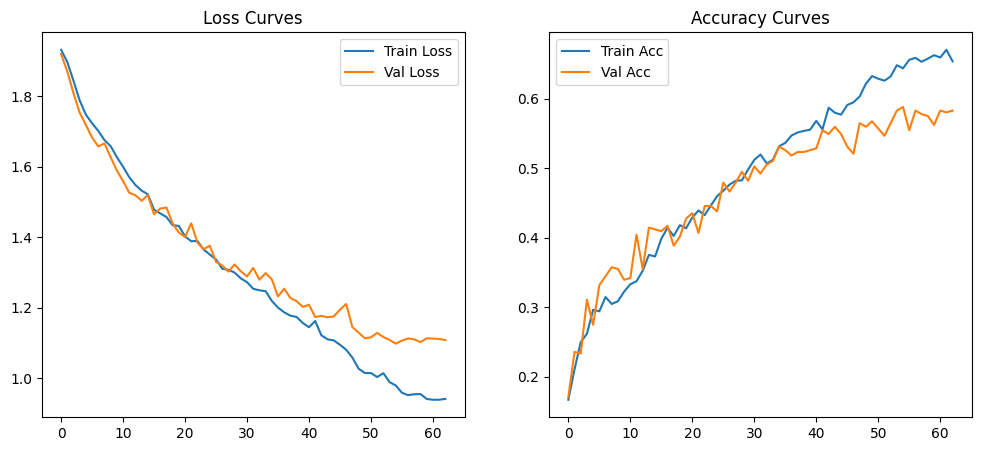

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss Curves')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy Curves')
plt.show()

In [12]:
model.save("final_model.h5")       # Full model
